In [1]:
import os
import shutil


def split_dataset(paths, orgin_dir, name):
    train_ratio = 0.6
    validation_ratio = 0.2
    test_ratio = 0.2
    size = len(paths)
    train_val_boundary = int(size * train_ratio)
    val_test_boundary = int(-1 * (size * test_ratio))
    train_dir = "dataset/Train"
    val_dir = "dataset/Validation"
    test_dir = "dataset/Test"
    os.makedirs(os.path.join(train_dir, name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, name), exist_ok=True)
    for path in paths[:train_val_boundary]:
        shutil.copy(os.path.join(orgin_dir, path), os.path.join(train_dir, name))
    for path in paths[train_val_boundary:val_test_boundary]:
        shutil.copy(os.path.join(orgin_dir, path), os.path.join(val_dir, name))
    for path in paths[val_test_boundary:]:
        shutil.copy(os.path.join(orgin_dir, path), os.path.join(test_dir, name))


boot_paths = os.listdir("dataset/Shoe vs Sandal vs Boot Dataset/Boot")
shoe_paths = os.listdir("dataset/Shoe vs Sandal vs Boot Dataset/Shoe")
sandal_paths = os.listdir("dataset/Shoe vs Sandal vs Boot Dataset/Sandal")

split_dataset(boot_paths, "dataset/Shoe vs Sandal vs Boot Dataset/Boot", "Boot")
split_dataset(shoe_paths, "dataset/Shoe vs Sandal vs Boot Dataset/Shoe", "Shoe")
split_dataset(sandal_paths, "dataset/Shoe vs Sandal vs Boot Dataset/Sandal", "Sandal")


In [2]:
from keras import utils


IMAGE_SIZE = (256, 256)


train_data = utils.image_dataset_from_directory(
    "dataset/Train",
    image_size=IMAGE_SIZE,
    seed=1998,
)
val_data = utils.image_dataset_from_directory(
    "dataset/Validation",
    image_size=IMAGE_SIZE,
    seed=1998,
)
test_data = utils.image_dataset_from_directory(
    "dataset/Test",
    image_size=IMAGE_SIZE,
    seed=1998,
)
train_data.class_names


2022-10-31 13:13:23.171129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 13:13:23.324996: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-31 13:13:24.010242: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-31 13:13:24.010323: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

Found 9000 files belonging to 3 classes.


2022-10-31 13:13:25.863839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-31 13:13:25.873098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-31 13:13:25.873599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-31 13:13:25.874228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Found 3000 files belonging to 3 classes.
Found 3000 files belonging to 3 classes.


['Boot', 'Sandal', 'Shoe']

In [3]:
import tensorflow as tf

def get_resnetv2(image_size):
    resnetv2 = tf.keras.applications.resnet_v2.ResNet50V2(
        include_top=False,
        weights="imagenet",
        input_shape=(*image_size, 3)
    )
    resnetv2.trainable = False
    resnetv2.get_layer("conv5_block3_1_conv").trainable = True
    resnetv2.get_layer("conv5_block3_2_conv").trainable = True
    resnetv2.get_layer("conv5_block3_3_conv").trainable = True
    return resnetv2

get_resnetv2(IMAGE_SIZE).summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [4]:

def get_pretrained_model(image_size, resnetv2):
    model_in = tf.keras.layers.Input((*image_size, 3))
    # Data augmentation stage
    x = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")(model_in)
    x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
    x = tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)(x)
    # Extraction stage
    x = tf.keras.applications.resnet_v2.preprocess_input(x)
    x = resnetv2(x)
    # Classification stage
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer="l2")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer="l2")(x)
    model_out = tf.keras.layers.Dense(3, activation="softmax")(
        x
    )
    # Return model
    return tf.keras.Model(inputs=[model_in], outputs=[model_out])


pretrained_model = get_pretrained_model(IMAGE_SIZE, get_resnetv2(IMAGE_SIZE))
pretrained_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0     

In [5]:
pretrained_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_sparse_categorical_accuracy", patience=5, restore_best_weights=True
)


In [7]:
prepretrained_model_history =pretrained_model.fit(
    train_data,
    batch_size=32,
    epochs=100,
    validation_data=val_data,
    callbacks=[early_stopping],
)


Epoch 1/100


2022-10-31 13:13:39.757372: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-10-31 13:13:40.277343: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


282/282 [==============================] - 131s 438ms/step - loss: 10.8125 - sparse_categorical_accuracy: 0.8234 - val_loss: 2.3697 - val_sparse_categorical_accuracy: 0.8503
Epoch 2/100
282/282 [==============================] - 122s 431ms/step - loss: 2.0478 - sparse_categorical_accuracy: 0.8580 - val_loss: 1.5638 - val_sparse_categorical_accuracy: 0.9020
Epoch 3/100
282/282 [==============================] - 123s 434ms/step - loss: 1.6664 - sparse_categorical_accuracy: 0.8694 - val_loss: 1.2568 - val_sparse_categorical_accuracy: 0.9493
Epoch 4/100
282/282 [==============================] - 121s 428ms/step - loss: 1.5437 - sparse_categorical_accuracy: 0.8708 - val_loss: 1.1373 - val_sparse_categorical_accuracy: 0.9483
Epoch 5/100
282/282 [==============================] - 121s 428ms/step - loss: 1.4522 - sparse_categorical_accuracy: 0.8744 - val_loss: 1.0766 - val_sparse_categorical_accuracy: 0.9550
Epoch 6/100
282/282 [==============================] - 120s 427ms/step - loss: 1.3690 

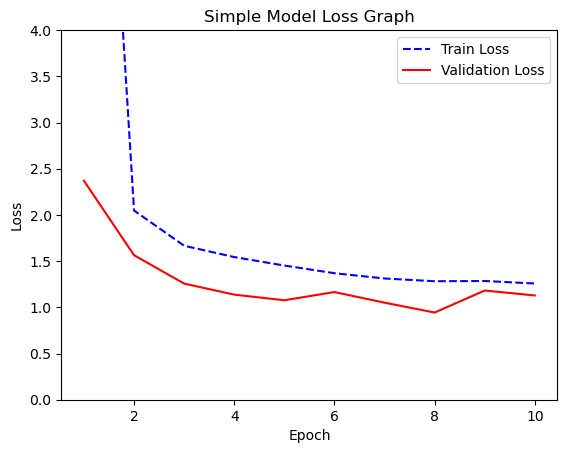

In [8]:
import matplotlib.pyplot as plt
epoch_range = range(1, len(prepretrained_model_history.history["loss"]) + 1)
plt.plot(epoch_range, prepretrained_model_history.history["loss"], "b--", label="Train Loss")
plt.plot(epoch_range, prepretrained_model_history.history["val_loss"], "r", label="Validation Loss")
plt.ylim(0, 4)
plt.title("Simple Model Loss Graph")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

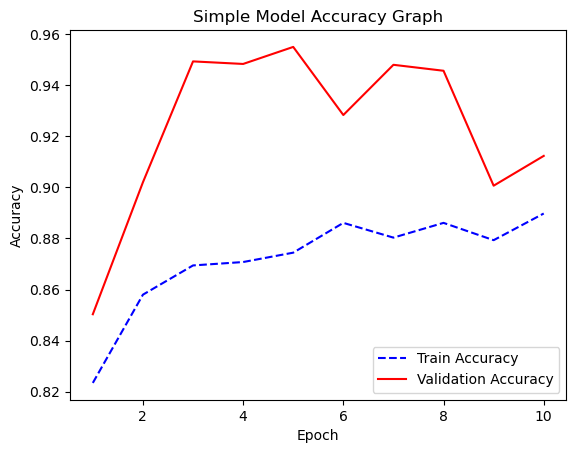

In [9]:
import matplotlib.pyplot as plt
epoch_range = range(1, len(prepretrained_model_history.history["sparse_categorical_accuracy"]) + 1)
plt.plot(epoch_range, prepretrained_model_history.history["sparse_categorical_accuracy"], "b--", label="Train Accuracy")
plt.plot(epoch_range, prepretrained_model_history.history["val_sparse_categorical_accuracy"], "r", label="Validation Accuracy")
plt.title("Simple Model Accuracy Graph")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [11]:
test_scores = pretrained_model.evaluate(test_data, return_dict=True)
test_scores

94/94 [==============================] - 7s 67ms/step - loss: 1.0792 - sparse_categorical_accuracy: 0.9557


{'loss': 1.0792231559753418, 'sparse_categorical_accuracy': 0.9556666612625122}